In [22]:
import overreact as rx
import jax.numpy as jnp
from overreact.simulate import _adjust_k
import numpy as np
from jax import jit

k = np.array([1e2, 1e-3, 1e5, 1e-6])
scheme = rx.parse_reactions("A + B<=> C‡ <=> D")

A = jnp.asarray(scheme.A) # A matrix of stoichiometric coefficients between reactants and products.
M = jnp.where(A > 0, 0, -A).T
k_adj = _adjust_k(scheme, k, ef=1)


def _dydt(t, y):  # noqa: ARG001
    r = k_adj * jnp.prod(jnp.power(y, M), axis=1)
    return jnp.dot(A, r)

_dydt = jit(_dydt)

In [24]:
_dydt(0, np.array([2,2,0,0]))

Array([-4000., -4000.,     0.,  4000.], dtype=float64)

In [17]:
jnp.power(jnp.array([2, 1, 0, 0]), M)

Array([[1., 1., 1., 1.],
       [2., 1., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]], dtype=float64)

# 1. Generating a list of reaction rate (k) given the reaction data

In [1]:
import overreact as rx
from overreact import _constants as constants
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the reaction data
rxn_data = "reaction_data_test.csv"

df = pd.read_csv(rxn_data)
energy_profile = df.values[0][1:-1]
rxn_species = df.columns.to_list()[1:-1]
dgr = df.values[0][-1]
coeff_TS = [1 if "TS" in element else 0 for element in rxn_species]

coeff_TS = np.array(coeff_TS)
energy_profile = np.array(energy_profile)

In [2]:
def get_dG_ddag(energy_profile, dgr, coeff_TS):
    
    # compute all dG_ddag in the profile
    n_S = energy_profile.size
    n_TS = np.count_nonzero(coeff_TS)
    n_I = np.count_nonzero(coeff_TS == 0)

    try:
        assert energy_profile.size == coeff_TS.size
    except AssertionError:
        print(
            f"WARNING: The species number {n_S} does not seem to match the identified intermediates ({n_I}) plus TS ({n_TS})."
        )
        
    X_TOF = np.zeros((n_I, 2))
    matrix_T_I = np.zeros((n_I, 2))

    j = 0
    for i in range(n_S):
        if coeff_TS[i] == 0:
            matrix_T_I[j, 0] = energy_profile[i]
            if i < n_S - 1:
                if coeff_TS[i + 1] == 1:
                    matrix_T_I[j, 1] = energy_profile[i + 1]
                if coeff_TS[i + 1] == 0:
                    if energy_profile[i + 1] > energy_profile[i]:
                        matrix_T_I[j, 1] = energy_profile[i + 1]
                    else:
                        matrix_T_I[j, 1] = energy_profile[i]
                j += 1
            if i == n_S - 1:
                if dgr > energy_profile[i]:
                    matrix_T_I[j, 1] = dgr
                else:
                    matrix_T_I[j, 1] = energy_profile[i]
 
    dG_ddag = matrix_T_I[:, 1] - matrix_T_I[:, 0]

    return dG_ddag

In [4]:
dG_ddag_reverse = get_dG_ddag(energy_profile, dgr, coeff_TS)
dG_ddag_reverse

array([ 5., 13., 19., 25.])

In [5]:
coeff_TS_reverse = coeff_TS[::-1]
coeff_TS_reverse = np.insert(coeff_TS_reverse, 0 , 0)
coeff_TS_reverse = coeff_TS_reverse[:-1]
energy_profile_reverse = energy_profile[::-1]
energy_profile_reverse = energy_profile_reverse[:-1]
energy_profile_reverse = energy_profile_reverse - dgr
energy_profile_reverse = np.insert(energy_profile_reverse, 0 , 0)
dG_ddag_reverse = get_dG_ddag(energy_profile_reverse, -dgr, coeff_TS_reverse)

In [6]:
print(f"Reaction profile: {energy_profile} + reaction energy of {dgr}")
print(f"forward: {get_dG_ddag(energy_profile, dgr, coeff_TS)}")
print(f"reverse: {get_dG_ddag(energy_profile_reverse, -dgr, coeff_TS_reverse)}")

Reaction profile: [0 5 -5 8 -4 15 -20 5] + reaction energy of -30
forward: [ 5. 13. 19. 25.]
reverse: [35. 35. 12. 10.]


In [7]:
k_reverse = rx.rates.eyring(
    dG_ddag_reverse*constants.kcal, # if energies are in kcal/mol: multiply them with `constants.kcal``
    temperature=298.15, # K
    pressure=1, # atm
    volume=None, # molecular volume
)
k_reverse

array([1.37430787e-13, 1.37430787e-13, 9.93575850e+03, 2.90543524e+05])

In [4]:
def get_k(energy_profile, dgr, coeff_TS, temperature = 298.15):
    """Compute reaction rates(k) for a reaction profile.

    Parameters
    ----------
    energy_profile : array-like
        The relative free energies profile (in kcal/mol)
    dgr : float
        free energy of the reaction
    coeff_TS : one-hot array
        one-hot encoding of the elements that are "TS" along the reaction coordinate.
    temperature : float

    Returns
    -------
    k_forward : array-like
        Reaction rates of all every forward steps
    k_reverse : array-like
        Reaction rates of all every backward steps (order as k-1, k-2, ...)
    """

    def get_dG_ddag(energy_profile, dgr, coeff_TS):

        # compute all dG_ddag in the profile
        n_S = energy_profile.size
        n_TS = np.count_nonzero(coeff_TS)
        n_I = np.count_nonzero(coeff_TS == 0)

        try:
            assert energy_profile.size == coeff_TS.size
        except AssertionError:
            print(
                f"WARNING: The species number {n_S} does not seem to match the identified intermediates ({n_I}) plus TS ({n_TS})."
            )
            
        X_TOF = np.zeros((n_I, 2))
        matrix_T_I = np.zeros((n_I, 2))

        j = 0
        for i in range(n_S):
            if coeff_TS[i] == 0:
                matrix_T_I[j, 0] = energy_profile[i]
                if i < n_S - 1:
                    if coeff_TS[i + 1] == 1:
                        matrix_T_I[j, 1] = energy_profile[i + 1]
                    if coeff_TS[i + 1] == 0:
                        if energy_profile[i + 1] > energy_profile[i]:
                            matrix_T_I[j, 1] = energy_profile[i + 1]
                        else:
                            matrix_T_I[j, 1] = energy_profile[i]
                    j += 1
                if i == n_S - 1:
                    if dgr > energy_profile[i]:
                        matrix_T_I[j, 1] = dgr
                    else:
                        matrix_T_I[j, 1] = energy_profile[i]
                        
        dG_ddag = matrix_T_I[:, 1] - matrix_T_I[:, 0]

        return dG_ddag
    
    dG_ddag_forward = get_dG_ddag(energy_profile, dgr, coeff_TS)
    
    coeff_TS_reverse = coeff_TS[::-1]
    coeff_TS_reverse = np.insert(coeff_TS_reverse, 0 , 0)
    coeff_TS_reverse = coeff_TS_reverse[:-1]
    energy_profile_reverse = energy_profile[::-1]
    energy_profile_reverse = energy_profile_reverse[:-1]
    energy_profile_reverse = energy_profile_reverse - dgr
    energy_profile_reverse = np.insert(energy_profile_reverse, 0 , 0)
    dG_ddag_reverse = get_dG_ddag(energy_profile_reverse, -dgr, coeff_TS_reverse)
    
    
    k_forward = rx.rates.eyring(
        dG_ddag_forward*constants.kcal, # if energies are in kcal/mol: multiply them with `constants.kcal``
        temperature=temperature, # K
        pressure=1, # atm
        volume=None, # molecular volume
    )
    k_reverse = rx.rates.eyring(
        dG_ddag_reverse*constants.kcal, # if energies are in kcal/mol: multiply them with `constants.kcal``
        temperature=temperature, # K
        pressure=1, # atm
        volume=None, # molecular volume
    )
    
    return k_forward, k_reverse[::-1]

# k_forward, k_reverse = get_k(energy_profile, dgr, coeff_TS, temperature = 298.15)

Reaction data from WIRES Comput Mol Sci 2018

In [10]:
# read the reaction data
rxn_data = "reaction_data_test.csv"

df = pd.read_csv(rxn_data)
energy_profile = df.values[0][1:-1]
rxn_species = df.columns.to_list()[1:-1]
dgr = df.values[0][-1]
coeff_TS = [1 if "TS" in element else 0 for element in rxn_species]
coeff_TS = np.array(coeff_TS)
energy_profile = np.array(energy_profile)

k_forward, k_reverse = get_k(energy_profile, dgr, coeff_TS, temperature = 298.15)

In [15]:
k_reverse

array([2.90543524e+05, 9.93575850e+03, 1.37430787e-13, 1.37430787e-13])

# 2. Generate a system of DE
Input
1. reaction rates
2. initial concentration
3. reaction network


To be checked before runing
- number of eqn = number of INT and reactants
- initial condition for all



[-161219614.98490408, 161219614.98490408, 0.0, 0.0, -161219614.98490408, 0.0, 0.0]
[-161185619.06148472, 161185619.0324334, 0.02905132498407927, 0.0, -161185619.06148472, -0.02905132498407927, 0.0]
[-161185626.22982553, 161185626.20078033, 0.0290451989516396, 4.1871014664852753e-16, -161185626.22982553, -0.02904519895164002, 0.0]
[-161151640.1575847, 161151640.0994943, 0.058090400486734674, 8.372437070695703e-16, -161151640.1575847, -0.05809040048673551, 4.826813310580677e-34]
[-161151647.32328212, 161151647.26519784, 0.0580842762294626, 1.255865597839112e-15, -161151647.32328212, -0.058084276229463855, 7.2392021391475505e-34]
[-156730526.6546635, 156730522.79842278, 3.8562407183333636, 3.794553530850359e-12, -156730526.6546635, -3.8562407183371583, 4.3422626272129826e-30]
[-156729334.06592858, 156729330.20865795, 3.857270622371379, 3.7430581070008545e-12, -156729334.06592858, -3.8572706223751223, 1.4511113044908143e-28]
[-152474151.30300686, 152474143.75228652, 7.550720327848582, 1.47

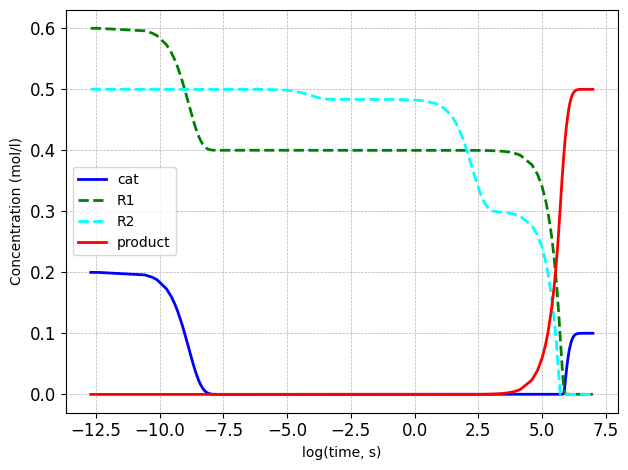

In [11]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def kinetic_system_de(t, y, k):

    dydt = [None for _ in range(k)] 
    dydt[0] = -k_forward[0]*y[0]*y[4] + k_reverse[0]*y[1] + k_forward[3]*y[3] - k_reverse[3]*y[0]*y[6]
    dydt[1] = k_forward[0]*y[0]*y[4] - k_reverse[0]*y[1] - k_forward[1]*y[1]*y[5] + k_reverse[1]*y[2]
    dydt[2] = k_forward[1]*y[1]*y[5] -  k_reverse[1]*y[2] - k_forward[2]*y[2] + k_reverse[2]*y[3]
    dydt[3] = k_forward[2]*y[2] - k_reverse[2]*y[3] - k_forward[3]*y[3] + k_reverse[3]*y[0]*y[6]
    dydt[4] = -k_forward[0]*y[0]*y[4] + k_reverse[0]*y[1]
    dydt[5] = -k_forward[1]*y[1]*y[5] + k_reverse[1]*y[2]
    dydt[6] = k_forward[3]*y[3] - k_reverse[3]*y[0]*y[6]

    print(dydt)

    return dydt

y0 = [0.2, 0.0, 0.0, 0.0, 0.6, 0.5, 0.0]  # Initial concentration of all species
t_span = (0.0, 1e7) 
result_solve_ivp = solve_ivp(
        kinetic_system_de,
        t_span,
        y0,
        method="LSODA",
        dense_output=True,
        rtol=1e-3, 
        atol=1e-6,
        jac=None,
        args=(7,),
        )

target = result_solve_ivp.y[5, :]


plt.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[0, :], '-b', linewidth=2, label='cat')
plt.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[4, :], '--g', linewidth=2, label='R1')
plt.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[5, :], '--', color="cyan", linewidth=2, label='R2')
plt.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[6, :], '-r', linewidth=2, label='product')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('log(time, s)')
plt.ylabel('Concentration (mol/l)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [12]:
# input
k_forward, k_reverse
Rp = np.array([[1, 0], 
               [0, 1], 
               [0, 0], 
               [0, 0]])

Pp = np.array([[0], 
               [0], 
               [0], 
               [1]])

n = len(k_forward)
n_INT = np.count_nonzero(coeff_TS == 1)
k = n_INT + Rp.shape[1] + Pp.shape[1]

y = np.array([0.2, 0.1, 0.2, 0.3, 2, 2, 0.1]) # Initial concentration of all species
t_span = (0.0, 1e7) 

In [13]:
def dINTa_dt(y, k_forward, k_reverse, Rp, Pp, a, n_INT):
    
    """from DE for INT

    Parameters
    ----------
    k_forward : list of forward rxn rate constant
    k_reverse : list of reverse rxn rate constant
    Rp : coordinate/stoichiometric matrix of the reactants
    Pp : coordinate/stoichiometric matrix of the product
    a : INT index [0,1,2,...]
    """

    y_INT = y[:n_INT]
    y_R = y[n_INT:n_INT+Rp.shape[1]]
    y_P = y[n_INT+Rp.shape[1]:]
    星町 = 0

    idx1 = np.where(Rp[a-1] != 0)[0]
    if idx1.size == 0: sui = 1
    else:
        常闇 = Rp[a-1]*y_R[idx1].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 += k_forward[a-1]*y_INT[a-1]*sui

    idx2 = np.where(Rp[a] != 0)[0]
    if idx2.size == 0: sui = 1
    else:
        常闇 = Rp[a]*y_R[idx2].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)     
    星町 -= k_forward[a]*y_INT[a]*sui

    idx3 = np.where(Pp[a] != 0)[0]
    if idx3.size == 0: sui = 1
    else:
        常闇 = Pp[a]*y_P[idx3].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    try:
        星町 += k_reverse[a]*y_INT[a+1]*sui
    except IndexError as err:
        星町 += k_reverse[a]*y_INT[-1]*sui

    idx4 = np.where(Pp[a-1] != 0)[0]
    if idx4.size == 0: sui = 1
    else:
        常闇 = Pp[a-1]*y_P[idx4].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 -= k_reverse[a-1]*y_INT[a]*sui
    print(idx4)

    return 星町

# Assume a particular Ri enters the cycle at one specific step
def dRa_dt(y, k_forward, k_reverse, Rp, Pp, a, n_INT):
    """from DE for INT

    Parameters
    ----------
    k_forward : list of forward rxn rate constant
    k_reverse : list of reverse rxn rate constant
    Rp : rxn coordinate matrix of the reactants
    Pp : rxn coordinate matrix of the product
    a : index of INT that the reactant engages
    """
    
    y_INT = y[:n_INT]
    y_R = y[n_INT:n_INT+Rp.shape[1]]
    y_P = y[n_INT+Rp.shape[1]:]

    星町 = 0
    a += 1
    
    idx1 = np.where(Rp[a-1] != 0)[0]
    if idx1.size == 0: sui = 1
    else:
        常闇 = Rp[a-1]*y_R[idx1].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 -= k_forward[a-1]*y_INT[a-1]*sui

    idx4 = np.where(Pp[a-1] != 0)[0]
    if idx4.size == 0: sui = 1
    else:
        常闇 = Pp[a-1]*y_P[idx4].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 += k_reverse[a-1]*y_INT[a]*sui

    return 星町

# Assume a particular Pi exits the cycle at one specific step
def dPa_dt(y, k_forward, k_reverse, Rp, Pp, a, n_INT):
    
    """from DE for product a

    Parameters
    ----------
    k_forward : list of forward rxn rate constant
    k_reverse : list of reverse rxn rate constant
    Rp : rxn coordinate matrix of the reactants
    Pp : rxn coordinate matrix of the product
    a : index of INT from where dissociates
    """
     
    y_INT = y[:n_INT]
    y_R = y[n_INT:n_INT+Rp.shape[1]]
    y_P = y[n_INT+Rp.shape[1]:]

    星町 = 0
    a += 1
    
    idx1 = np.where(Rp[a-1] != 0)[0]
    if idx1.size == 0: sui = 1
    else:
        常闇 = Rp[a-1]*y_R[idx1].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 += k_forward[a-1]*y_INT[a-1]*sui

    idx4 = np.where(Pp[a-1] != 0)[0]
    if idx4.size == 0: sui = 1
    else:
        常闇 = Pp[a-1]*y_P[idx4].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    try:
        星町 -= k_reverse[a-1]*y_INT[a]*sui
    except IndexError as err:
        星町 -= k_reverse[a-1]*y_INT[0]*sui
    
    return 星町


[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]
[0]
[]
[]
[]

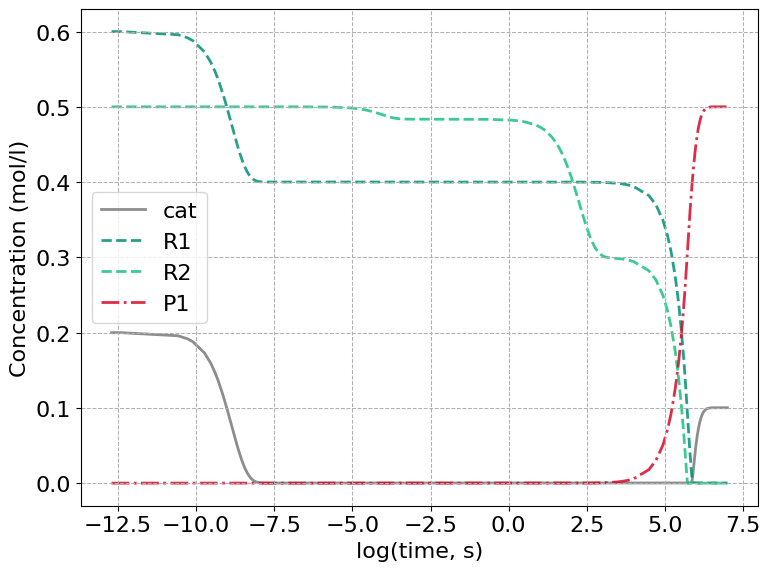

In [14]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def kinetic_system_de(t, y, k, n_INT, Rp, Pp):
    
    """"Forming the system of DE for kinetic modelling"""
    
    dydt = [None for _ in range(k)] 
    for i in range(n_INT):
        dydt[i] = dINTa_dt(y, k_forward, k_reverse, Rp, Pp, i, n_INT)
    
    for i in range(Rp.shape[1]):
        a_R = np.where(Rp[:,i] == 1)[0]
        for a in a_R:
            dydt[i + n_INT] = dRa_dt(y, k_forward, k_reverse, Rp, Pp, a, n_INT)
    
    for i in range(Pp.shape[1]):
        a_R = np.where(Pp[:,i] == 1)[0]
        for a in a_R:
            dydt[i + n_INT + Rp.shape[1]] = dPa_dt(y, k_forward, k_reverse, Rp, Pp, a, n_INT)    
    return dydt

y0 = [0.2, 0.0, 0.0, 0.0, 0.6, 0.5, 0.0]  # Initial concentration of all species
result_solve_ivp = solve_ivp(
        kinetic_system_de,
        t_span,
        y0,
        method="LSODA",
        dense_output=True,
        rtol=1e-3, 
        atol=1e-6,
        jac=None,
        args=(k, n_INT, Rp, Pp, ),
        )

target = result_solve_ivp.y[5, :]



plt.rc("axes", labelsize=16)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("font", size=16)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[0, :], c="#797979", linewidth=2, alpha=0.85, zorder=1, label='cat')

result_solve_ivp.y.shape[0] - n_INT

博衣 = ["#008F73", "#1AC182", "#1AC145", "#7FFA35", "#8FD810", "#ACBD0A"]
for i in range(Rp.shape[1]):
    ax.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[n_INT+i, :], linestyle="--",
            c=博衣[i], linewidth=2, alpha=0.85, zorder=1, label=f'R{i+1}')
    
こより = ["#D80828", "#DA475D", "#FC2AA0", "#F92AFC", "#A92AFC", "#602AFC"]
for i in range(Pp.shape[1]):
    ax.plot(np.log10(result_solve_ivp.t), result_solve_ivp.y[n_INT+Rp.shape[1]+i, :], linestyle="dashdot",
            c=こより[i], linewidth=2, alpha=0.85, zorder=1, label=f'P{i+1}')

plt.xlabel('log(time, s)')
plt.ylabel('Concentration (mol/l)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.75)
plt.tight_layout()
plt.show()

In [15]:
result_solve_ivp.y.shape[0] - n_INT

3

In [16]:
import numpy as np

In [17]:
np.savetxt('c0.txt', np.array([0.2, 0.1, 0.2, 0.3, 2. , 2. , 0.1]))


In [18]:
np.savetxt('cat.txt', result_solve_ivp.y[0,:])
np.savetxt('Rs.txt', result_solve_ivp.y[n_INT:n_INT+Rp.shape[1],:])
np.savetxt('Ps.txt', result_solve_ivp.y[n_INT+Rp.shape[1]:])

In [19]:
result_solve_ivp.y[n_INT:n_INT+Rp.shape[1],:].shape

(2, 345)

In [20]:
x = np.loadtxt("Pp.txt")
x.reshape(4,1)

array([[0.],
       [0.],
       [0.],
       [1.]])